In [3]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
#Plot Maps
import geopandas
import pycountry 
from ipywidgets import interact, IntSlider

from sklearn.impute import SimpleImputer
import datetime

import os

In [10]:
nd = pd.read_csv('../Dataset/EMDAT_1900-2021_NatDis.csv')

In [11]:
def basic_EDA(df):
    size = df.shape
    sum_duplicates = df.duplicated().sum()
    sum_null = df.isnull().sum().sum()
    is_NaN = df. isnull()
    row_has_NaN = is_NaN. any(axis=1)
    rows_with_NaN = df[row_has_NaN]
    count_NaN_rows = rows_with_NaN.shape
    return print("Number of Samples: %d,\nNumber of Features: %d,\nDuplicated Entries: %d,\nNull Entries: %d,\nNumber of Rows with Null Entries: %d %.1f%%" %(size[0],size[1], sum_duplicates, sum_null,count_NaN_rows[0],(count_NaN_rows[0] / df.shape[0])*100))

def summary_table(df):

    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    return summary

def heatmap(df, index,columns,values,vmax,Title):
    DisasterDuration_wide = df.pivot(index=index, columns=columns, values=values)
    #DisasterDuration_wide = DisasterDuration_wide.sort_values(by = sort_by, ascending = False)#ignore_index = True)

    plt.figure(figsize=(12,8))

    ax = sns.heatmap(DisasterDuration_wide, annot=True, fmt='.0f', yticklabels='auto', cmap=sns.color_palette("YlGnBu", as_cmap=True), center=.2,vmin = 0, vmax = vmax,linewidths=.5)
    ax.xaxis.tick_top() # x axis on top
    ax.xaxis.set_label_position('top')
    ax.set_title(Title,fontsize = 16,weight = 'bold',pad=20)
    plt.show()
    
def histplot(df, x, x_axis_title,y_axys_title, plot_title):
    plt.figure(figsize=(20,8))
    sns.set(style="ticks", font_scale = 1)
    ax = sns.countplot(data = df,x=x)
    plt.xticks(rotation=70,fontsize = 8)
    ax.set_xlabel(x_axis_title)
    ax.set_ylabel(y_axys_title)
    plt.title(plot_title, fontsize = 16,weight = 'bold')    

def bar_plot(x,y,xlabel,ylabel,title, label):
    plt.figure(figsize=(20,5))
    sns.set(style="ticks", font_scale = 1)
    ax = sns.barplot(x=x, y = y, palette="Blues_d")
    sns.despine(top=True, right=True, left=True, bottom=False)
    plt.xticks(rotation=90,fontsize = 12)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.title(title)
    
    if label == 'percent':
        for p in ax.patches:
                     ax.annotate("%.1f%%" % (100*float(p.get_height()/15827)), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
                         ha='center', va='bottom', color='black', xytext=(0, 10),rotation = 'vertical',
                         textcoords='offset points')
    if label == 'number':
        for p in ax.patches:
             ax.annotate("%d" % p.get_height(), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
                 ha='center', va='bottom', color='black', xytext=(0, 10),rotation = 'horizontal',
                 textcoords='offset points')
    

def Null_Analysis(df,title):
    null_columns=df.columns[df.isnull().any()]
    null_columns_plot = df[null_columns].isnull().sum().sort_values(ascending = False)
    bar_plot(null_columns_plot.index, null_columns_plot,"Features", "Number of Null Values", title, 'percent')

#Get 3 Letters code from Countries List to plot Map
def alpha3code(column):
    CODE=[]
    for country in column:
        try:
            code=pycountry.countries.get(name=country).alpha_3
           # .alpha_3 means 3-letter country code 
           # .alpha_2 means 2-letter country code
            CODE.append(code)
        except:
            CODE.append('None')
    return CODE

In [27]:
def eventsWithoutPreciseLocationInfo(df):
    type_set = {}
    cnt = 0

    for index, row in df.iterrows():
        if (pd.isna(df.loc[index, 'Location']) and (pd.isna(df.loc[index, 'Latitude']) or pd.isna(df.loc[index, 'Longitude']))):
            type_val = row['Disaster Type']
            subtype_val = row['Disaster Subtype']

            type_obj = type_set.get(type_val, {'cnt': 0, 'subtypes': {}})
            type_obj['cnt'] += 1
            type_obj['subtypes'][subtype_val] = type_obj['subtypes'].get(subtype_val, 0) + 1
            type_set[type_val] = type_obj

            cnt+=1

    print('total: ' + str(cnt))
    for k in type_set:
        print(k)
        print(type_set[k])

In [13]:
def prepareAndPlotMap(df, year_min=1900, year_max=2021):
    if (year_min > year_max):
        return
    
    Country = df.loc[:,['Dis No','Year','Continent','Disaster Type','Country']]

    #List of Countries not Originally found, Data Cleanse to map to python library names

    Country.loc[(Country.Country == 'Bahamas (the)'),'Country']='Bahamas'
    Country.loc[(Country.Country == 'Bolivia (Plurinational State of)'),'Country']='Bolivia, Plurinational State of'
    Country.loc[(Country.Country == 'Comoros (the)'),'Country']='Comoros'
    Country.loc[(Country.Country == 'Congo (the Democratic Republic of the)'),'Country']='Congo, the Democratic Republic of the'
    Country.loc[(Country.Country == 'Congo (the)'),'Country']='Congo'
    Country.loc[(Country.Country == 'Côte d’Ivoire'),'Country']="Côte d'Ivoire"
    Country.loc[(Country.Country == 'Czech Republic (the)'),'Country']="Czechia"
    Country.loc[(Country.Country == 'Dominican Republic (the)'),'Country']="Dominican Republic"
    Country.loc[(Country.Country == 'Gambia (the)'),'Country']="Gambia"
    Country.loc[(Country.Country == 'Iran (Islamic Republic of)'),'Country']="Iran, Islamic Republic of" 
    Country.loc[(Country.Country == "Korea (the Democratic People's Republic of)"),'Country']="Korea, Democratic People's Republic of" 
    Country.loc[(Country.Country == "Korea (the Republic of)"),'Country']="Korea, Republic of" 
    Country.loc[(Country.Country == "Lao People's Democratic Republic (the)"),'Country']="Lao People's Democratic Republic" 
    Country.loc[(Country.Country == "Macedonia (the former Yugoslav Republic of)"),'Country']="North Macedonia"
    Country.loc[(Country.Country == "Marshall Islands (the)"),'Country']="Marshall Islands" 
    Country.loc[(Country.Country == "Micronesia (Federated States of)"),'Country']="Micronesia, Federated States of" 
    Country.loc[(Country.Country == "Moldova (the Republic of)"),'Country']="Moldova, Republic of" 
    Country.loc[(Country.Country == "Netherlands (the)"),'Country']="Netherlands" 
    Country.loc[(Country.Country == "Niger (the)"),'Country']="Niger" 
    Country.loc[(Country.Country == "Philippines (the)"),'Country']="Philippines" 
    Country.loc[(Country.Country == "Russian Federation (the)"),'Country']="Russian Federation" 
    Country.loc[(Country.Country == "Sudan (the)"),'Country']="Sudan" 
    Country.loc[(Country.Country == "Taiwan (Province of China)"),'Country']="Taiwan, Province of China"
    Country.loc[(Country.Country == "United Arab Emirates (the)"),'Country']="United Arab Emirates"
    Country.loc[(Country.Country == "United Kingdom of Great Britain and Northern Ireland (the)"),'Country']="United Kingdom" 
    Country.loc[(Country.Country == 'United States of America (the)'),'Country']="United States" 
    Country.loc[(Country.Country == 'Venezuela (Bolivarian Republic of)'),'Country']='Venezuela, Bolivarian Republic of' 
    Country.loc[(Country.Country == 'Swaziland'),'Country']='Eswatini' 
    
    # Remember all of the countries
#     AllCountries = Country[['Country']].drop_duplicates(subset='Country')
    
    # Select data for only the relevant year range
    query_string = f'Year >= {year_min} and Year <= {year_max}'
    CountryCount = Country.query(query_string)
    CountryCount = CountryCount[['Country']]
    
    # Group by countries
    CountryCount = CountryCount.groupby(['Country']).size().reset_index(name='Count')
    
    # Add zeroes for missing countries
#     CountryCountTmp = AllCountries.merge(CountryCount, on='Country', how='left')
#     CountryCountTmp.loc[CountryCountTmp['Count'].isnull(), 'Count'] = 0
#     CountryCount = CountryCountTmp
    
    # Add country codes
    CountryCount['CountryCode'] = alpha3code(CountryCount.Country)
    
    #For the left join to work proeperly - CountryCode on the first Column
    CountryCount = CountryCount[['CountryCode','Country','Count']]

    world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
    #Remove Antartica
    world = world[(world.pop_est>0) & (world.name!="Antarctica")]
    # rename the columns so that we can merge with our data
    world.columns=['pop_est', 'continent', 'name', 'CountryCode', 'gdp_md_est', 'geometry']

    #Some countries are presenting -99 as 3 letter code, let's correct this - A bit more Data Cleanse
    #world[world['CountryCode'] =='-99']
    world.loc[(world.name == 'N. Cyprus', 'CountryCode')] = 'CYP'
    world.loc[(world.name == 'Somaliland', 'CountryCode')] = 'SOM'
    world.loc[(world.name == 'Kosovo', 'CountryCode')] = 'SRB'
    
    # with pd.option_context('display.max_rows', None,
    #                        'display.max_columns', None,
    #                        'display.precision', 3,
    #                        ):
    #     world = world.sort_values('continent')
    #     print(world[['name', 'CountryCode', 'continent']])

    # Left Join, otherwise missing countries appear as a blank on the plot
    CountryCount=world.merge(CountryCount,on='CountryCode',how='left')

    #Convert Lat and Long to different Coordinates (makes a nicer plot)
    CountryCount = CountryCount.to_crs("EPSG:3395")
    
    # Remove NaN rows
#     CountryCount = CountryCount.query('Country.isnull() == False and Count.isnull() == False')
    
#     with pd.option_context('display.max_rows', None,
#                            'display.max_columns', None,
#                            'display.precision', 3,
#                            ):
#         CountryCount = CountryCount.sort_values('Country')
#         print(CountryCount[['Country', 'CountryCode', 'Count']])
    
    fig, axarr = plt.subplots(1, 1, figsize=(15, 20))

    ax = CountryCount.plot(
        column='Count', ax=axarr, 
        legend=True, scheme='quantiles', 
        figsize=(15, 20), edgecolor='gray', cmap='OrRd',
        missing_kwds={
            "color": "lightgrey",
            "edgecolor": "lightgray",
            "label": "Missing values",
        }
    );


    if (year_min < year_max):
        axarr.set_title('Number of events per country between the years ' + str(year_min) + ' and ' + str(year_max),fontsize = 16,weight = 'bold')
    else:
        axarr.set_title('Number of events per country in ' + str(year_min),fontsize = 16,weight = 'bold')
        
    fig.patch.set_visible(False)
    axarr.axis('off')

    fig.tight_layout(pad=3.0)    
    plt.show()

In [14]:
basic_EDA(nd)

Number of Samples: 15827,
Number of Features: 43,
Duplicated Entries: 0,
Null Entries: 285923,
Number of Rows with Null Entries: 15827 100.0%


In [15]:
summary_table(nd)

,Name,dtypes,Missing,Uniques
0,Dis No,object,0,15827
1,Year,int64,0,122
2,Seq,int64,0,1266
3,Disaster Group,object,0,1
4,Disaster Subgroup,object,0,6
5,Disaster Type,object,0,15
6,Disaster Subtype,object,2984,27
7,Disaster Subsubtype,object,14782,12
8,Event Name,object,12024,1532
9,Entry Criteria,object,335,13


In [28]:
eventsWithoutPreciseLocationInfo(nd)

total: 1767
Volcanic activity
{'cnt': 35, 'subtypes': {'Ash fall': 35}}
Flood
{'cnt': 294, 'subtypes': {nan: 232, 'Riverine flood': 54, 'Coastal flood': 5, 'Flash flood': 3}}
Storm
{'cnt': 729, 'subtypes': {'Tropical cyclone': 404, nan: 255, 'Convective storm': 44, 'Extra-tropical storm': 26}}
Epidemic
{'cnt': 303, 'subtypes': {'Bacterial disease': 148, 'Viral disease': 131, 'Parasitic disease': 8, nan: 16}}
Drought
{'cnt': 156, 'subtypes': {'Drought': 156}}
Landslide
{'cnt': 63, 'subtypes': {'Avalanche': 7, nan: 3, 'Landslide': 53}}
Extreme temperature
{'cnt': 92, 'subtypes': {'Heat wave': 48, 'Cold wave': 41, 'Severe winter conditions': 3}}
Earthquake
{'cnt': 7, 'subtypes': {'Ground movement': 7}}
Wildfire
{'cnt': 49, 'subtypes': {'Forest fire': 21, 'Land fire (Brush, Bush, Pasture)': 28}}
Insect infestation
{'cnt': 36, 'subtypes': {'Locust': 24, nan: 3, 'Grasshopper': 9}}
Mass movement (dry)
{'cnt': 3, 'subtypes': {'Avalanche': 2, 'Landslide': 1}}


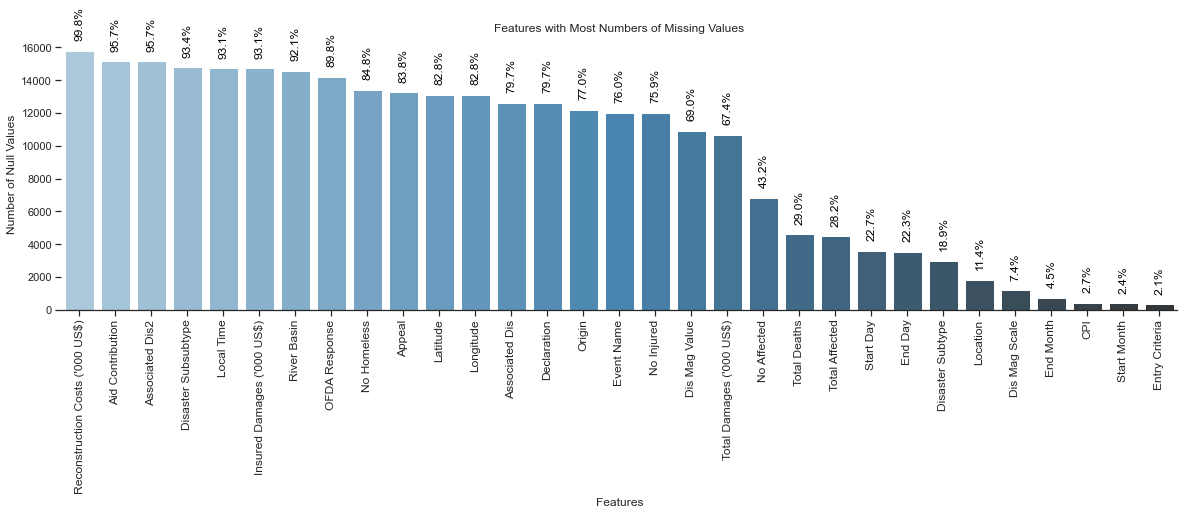

In [17]:
Null_Analysis(nd,'Features with Most Numbers of Missing Values')

In [18]:
# def prepareForSingleYear(year):
#     prepareAndPlotMap(year, year)
def prepareAndPlotMapWithData(min_year, max_year):
    prepareAndPlotMap(nd, min_year, max_year)

min_year_slider = IntSlider(min=1900, max=2021, step=1, value=1900, continuous_update = False)
# max_year_slider = IntSlider(min=1900, max=2021, step=1, value=2021, continuous_update = False)
max_year_slider = IntSlider(min=1900, max=2021, step=1, value=2021, continuous_update = False)
    
interact(prepareAndPlotMapWithData, min_year=min_year_slider, max_year=max_year_slider);

interactive(children=(IntSlider(value=1900, continuous_update=False, description='min_year', max=2021, min=190…

In [19]:
nd_soviet = nd.query('Country in ["Russian Federation (the)", "Tajikistan", "Soviet Union", "Ukraine", "Kazakhstan", "Azerbaijan", "Moldova (the Republic of)", "Lithuania", "Belarus", "Armenia", "Latvia", "Uzbekistan", "Estonia", "Turkmenistan"]')
nd_soviet = nd_soviet.sort_values('Year')
nd_soviet = nd_soviet[['Dis No', 'Year', 'Disaster Type', 'Country']]
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(nd_soviet)
print(len(nd_soviet.index))

              Dis No  Year        Disaster Type                    Country
869    1902-0011-SUN  1902           Earthquake               Soviet Union
13735  1902-0013-AZE  1902           Earthquake                 Azerbaijan
14357  1911-0020-KAZ  1911           Earthquake                 Kazakhstan
14359  1911-0021-TJK  1911           Earthquake                 Tajikistan
917    1917-0002-SUN  1917             Epidemic               Soviet Union
926    1921-9001-SUN  1921              Drought               Soviet Union
935    1923-0005-SUN  1923                Storm               Soviet Union
936    1923-0001-SUN  1923             Epidemic               Soviet Union
14375  1930-0032-TJK  1930           Earthquake                 Tajikistan
13754  1931-0019-ARM  1931           Earthquake                    Armenia
1056   1946-0023-SUN  1946           Earthquake               Soviet Union
1073   1948-0011-SUN  1948           Earthquake               Soviet Union
1082   1949-0001-SUN  194

In [20]:
nd_test = nd.query('(Country == "Soviet Union") and (Latitude.isnull() or Longitude.isnull())')
nd_test = nd_test[['Year', 'Country', 'Location']]

with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(nd_test)
    
print(len(nd_test.index))

      Year       Country                                           Location
917   1917  Soviet Union                                         Nationwide
926   1921  Soviet Union  South Ukraine, Volga, Ural (Kazakhstan,Russian...
935   1923  Soviet Union                        Rostov (Russian Federation)
936   1923  Soviet Union  Nationwide (Ukraine, Georgia, Russian Federati...
1082  1949  Soviet Union                               Khait (Tadzhikistan)
1186  1956  Soviet Union                     Kamchatka (Russian Federation)
1279  1961  Soviet Union                                     Kiev (Ukraine)
1692  1974  Soviet Union                     Pamir Mountains (Tadjikistan?)
3519  1981  Soviet Union                                               East
3520  1981  Soviet Union                                                NaN
3540  1982  Soviet Union                                            Siberia
3541  1982  Soviet Union                                               East
3567  1983  

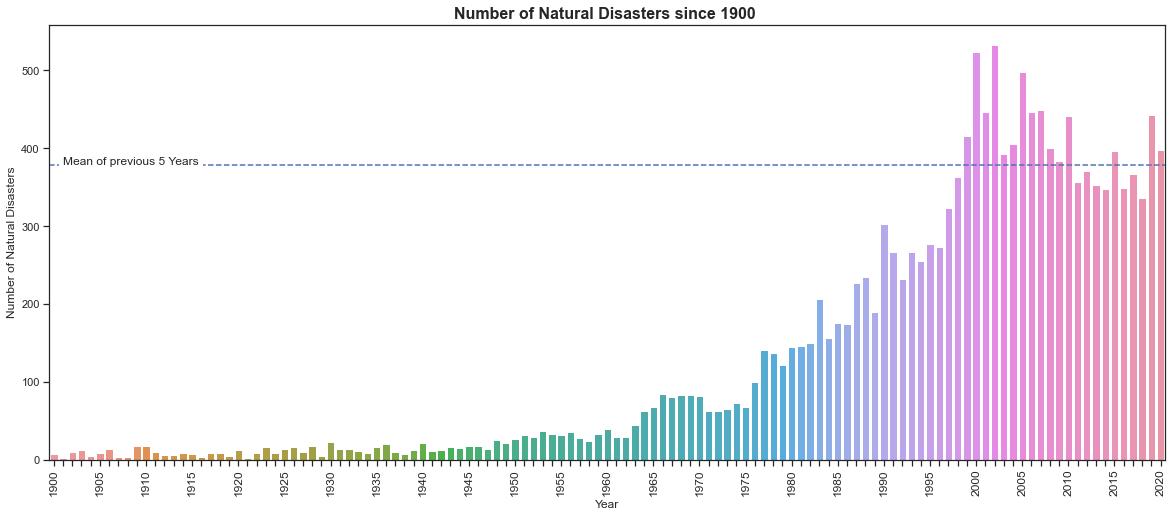

In [26]:
NDYears = nd.loc[:,['Year']]
NDYears = NDYears[(NDYears['Year'] <= 2020)]
NDYears = NDYears.groupby(['Year']).size().to_frame('Count').reset_index()

plt.figure(figsize=(20,8))

df = NDYears
mean5Years = df.iloc[-5:,1].mean()

ax = sns.barplot(data=df, x='Year', y = 'Count')

ax.axhline(mean5Years, ls='--', c = 'b')
ax.text(1,(mean5Years),"Mean of previous 5 Years",
        bbox=dict(facecolor='white', edgecolor='none'))
ax.set_title("Number of Natural Disasters since 1900 ", fontsize = 16,weight = 'bold');
ax.set_xlabel('Year')
ax.set_ylabel('Number of Natural Disasters')

plt.xticks(rotation=90,fontsize = 12)

for label in ax.get_xticklabels():
    if int(label.get_text()) % 5 == 0:  
        label.set_visible(True)
    else:
        label.set_visible(False)
plt.show()